In [2]:
import numpy as np
import numpy.random as rnd
import theano
import theano.tensor as T
import lasagne
import time
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_mnist_images(filename):
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data

def load_mnist_labels(filename):
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

# We can now download and read the training and test set images and labels.
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

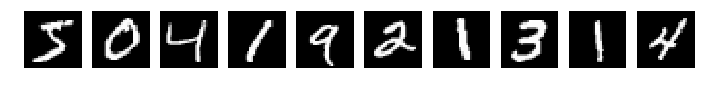

In [39]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [4]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [5]:
a = np.zeros((y_train.size, 10))
a[np.arange(y_train.size), y_train] = 1
y_train = a

In [6]:
a = np.zeros((y_test.size, 10))
a[np.arange(y_test.size), y_test] = 1
y_test = a

In [43]:
y_train.shape

(60000, 10)

In [7]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
GRAD_CLIP = 10
N_HIDDEN = 100
SEQ_LEN = 784
TRAIN_SIZE = 60000
TEST_SIZE = 10000

In [8]:
# numerically stable log-softmax with crossentropy
def logsoftmax(x):
    xdev = x-x.max(1,keepdims=True)
    lsm = xdev - T.log(T.sum(T.exp(xdev),axis=1,keepdims=True))
    return lsm

# cross-entropy
# ys are indices of chars, x is a matrix (? BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
def lsmCE(x,y):
    print(T.shape(x), T.shape(y))
    return -T.clip(x,-20,0)[T.arange(y.shape[0]), y]

In [9]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(network, inp, target, train_err, test_err, train_acc, test_acc, train_fn, test_fn):
    return {'network':network,
            'inp':inp,
            'target':target,
            
            'train_err':train_err,
            'test_err':test_err,
            'train_acc':train_acc, 
            'test_acc':test_acc, 
            'train_fn':train_fn, 
            'test_fn':test_fn
            } 

In [10]:
def init_posdef_w(n):
    # A = 1/N R^T * R, wehere R is standard normal
    # A is positive definite
    # W = (A + I) / max(spec(A + I))
    # spec(W) = {1, l_i < 1}
    
    R = np.random.normal(size=(n, n))
    A = 1 / N_HIDDEN * np.dot(R.T, R)
    eig, _ = np.linalg.eig(A + np.eye(n))
    e = max(eig)
    W = (A + np.eye(n)) / e
    return W

In [11]:
def build_network_np(inp, num_epochs=NUM_EPOCHS):
    # Network from paper "Improving performance of RNN with ReLU"
    # W_hh is initialized as pos. def. with max eigenvalue 1
    
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    alpha = np.sqrt(2) * np.exp(1.2 / (max(N_HIDDEN, 6)))
    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(std=alpha / N_HIDDEN, mean=0.0),
        W_hid_to_hid=init_posdef_w(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)

    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [12]:
def build_network_identity(inp, num_epochs=NUM_EPOCHS):
    # Network from paper "Simple way to initialize RNN",
    # W_hh is initialized as identity matrix
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(1e-3, mean=0.0),
        W_hid_to_hid=np.eye(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [13]:
def build_network_gaus(inp, num_epochs=NUM_EPOCHS):
    # W_hh is initialized from standard normal
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.GlorotNormal(),
        W_hid_to_hid=lasagne.init.Normal(),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [14]:
# Create a network with particular initialization for parameters
def create_network(build_fn):
    print("Building network ...")
    inp = T.tensor3('input', dtype='float64')
    # Matrix of size BATCH_SIZE * 10 to match network's output
    target_values = T.matrix('target_output', dtype='float64')
    network = build_fn(inp)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    return (network, inp, target_values)

In [15]:
def train_sgd(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, lr, num_epochs=NUM_EPOCHS):
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_err=np.zeros(num_epochs)
    train_acc=np.zeros(num_epochs)
    test_err=np.zeros(num_epochs)
    test_acc=np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)
    cr_ent = T.mean(lasagne.objectives.categorical_crossentropy(network_output, target_values))
    acc_score = lasagne.objectives.categorical_accuracy(
        network_output, target_values).mean(dtype=theano.config.floatX) * 100
    
    # Retrieve all parameters from the network
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cr_ent, all_params)
    scaled_grads, grad_norm = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP, return_norm=True)
    lr_var = theano.shared(lr)
    updates = lasagne.updates.sgd(scaled_grads, all_params, learning_rate=lr_var)

    print("Compiling functions ...")    
    train_fn = theano.function([inp, target_values], [cr_ent, acc_score, grad_norm],
                               updates=updates, allow_input_downcast=True)
    test_fn = theano.function([inp, target_values], [cr_ent, acc_score], allow_input_downcast=True)
    get_output = theano.function([inp], network_output, allow_input_downcast=True)
    
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]            
            err, acc, norm = train_fn(Xtrain[idx, :, np.newaxis], ytrain[idx, :])
            train_err[epoch] += err
            train_acc[epoch] += acc
            
            if batch == num_batches // 4:
                print("25%", end=" ")
            if batch == num_batches // 2:
                print("50%", end=" ")
            if batch == num_batches // 4 * 3:
                print("75%")
            
        train_err[epoch] /= num_batches
        train_acc[epoch] /= num_batches
        
        terr, tacc = test_fn(Xtest[:, :, np.newaxis], ytest)
        test_err[epoch] = terr
        test_acc[epoch] = tacc
        
        print("Epoch {} loss / acc test = {:.4f}, {:.4f} \t"
              "train = {:.4f}, {:.4f} norm = {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch], test_acc[epoch], 
                     train_err[epoch], train_acc[epoch], norm.item(), time.time() - start_time), end="\t")
    
    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_acc, test_acc, train_fn, test_fn)

In [16]:
net, inp, tar = create_network(build_network_np)
nprnn1 = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "nprnn1", 1e-4, num_epochs=10)
np.save("acc1", nprnn1["test_acc"])
np.save("err1", nprnn1["test_err"])

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 2.3023, 11.3500 	train = 2.3027, 11.1517 norm = 0.2568 	 time = 580.11s	25% 50% 75%
Epoch 1 loss / acc test = 2.3021, 11.3500 	train = 2.3022, 11.2367 norm = 0.2647 	 time = 580.26s	25% 50% 75%
Epoch 2 loss / acc test = 2.3018, 11.3500 	train = 2.3019, 11.2383 norm = 0.2657 	 time = 581.79s	25% 50% 75%
Epoch 3 loss / acc test = 2.3016, 11.3700 	train = 2.3017, 11.2417 norm = 0.2507 	 time = 582.40s	25% 50% 75%
Epoch 4 loss / acc test = 2.3013, 11.9500 	train = 2.3014, 11.7017 norm = 0.2568 	 time = 575.96s	25% 50% 75%
Epoch 5 loss / acc test = 2.3010, 11.9800 	train = 2.3011, 12.0217 norm = 0.2803 	 time = 577.58s	25% 50% 75%
Epoch 6 loss / acc test = 2.3008, 11.9900 	train = 2.3008, 12.0650 norm = 0.2666 	 time = 577.94s	25% 50% 75%
Epoch 7 loss / acc test = 2.3006, 12.0100 	train = 2.3006, 12.1017 norm = 0.2806 	 time = 581.46s	25% 50% 75%
Epoch 8 loss

In [119]:
# loss = []
# acc = []
# loss.append(nprnn1["test_err"])
# acc.append(nprnn1["test_acc"])

In [ ]:
nprnn1 = train_sgd(nprnn1["network"], nprnn1["inp"], nprnn1["target"],
                X_train, y_train, X_test, y_test, "nprnn1", 1e-4, num_epochs=23)
np.save("acc2", nprnn1["test_acc"])
np.save("err2", nprnn1["test_err"])

Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 2.2993, 12.1000 	train = 2.2993, 12.2500 norm = 0.2828 	 time = 670.16s	25% 50% 75%
Epoch 1 loss / acc test = 2.2983, 12.1100 	train = 2.2984, 12.2983 norm = 0.2835 	 time = 677.27s	25% 50% 75%
50% 75%
Epoch 8 loss / acc test = 2.0871, 18.1000 	train = 2.0360, 23.0950 norm = 13.1145 	 time = 640.36s	25% 50% 75%
Epoch 9 loss / acc test = 2.0835, 19.9500 	train = 2.0214, 23.9917 norm = 19.9003 	 time = 636.89s	25% 50% 75%
Epoch 10 loss / acc test = 2.1215, 19.6900 	train = 2.0096, 24.6000 norm = 28.7010 	 time = 638.69s	25% 50% 75%
Epoch 11 loss / acc test = 2.1448, 19.1400 	train = 2.0001, 24.8067 norm = 63.6304 	 time = 645.02s	25% 50% 75%
Epoch 12 loss / acc test = 2.2513, 18.6900 	train = 1.9928, 24.7100 norm = 119.3084 	 time = 635.18s	25% 50% 75%
Epoch 13 loss / acc test = 1.9589, 27.1900 	train = 1.9851, 24.8100 norm = 274.9250 	 time = 634.92s	25% 50% 75%
Epoch 14 loss / acc test = 1.9629, 27.0800

In [ ]:
# COOL DOWN LEARNING RATE AFTER 30 EPOCHS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [16]:
net, inp, tar = create_network(build_network_np)
weights = np.load("nprnn1.npy")
lasagne.layers.set_all_param_values(net, weights)
nprnn1 = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "nprnn1", 1e-5, num_epochs=33)
np.save("acc3", nprnn1["test_acc"])
np.save("err3", nprnn1["test_err"])

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 1.7963, 30.8900 	train = 1.7676, 32.0333 norm = 131.5668 	 time = 646.70s	25% 50% 75%
Epoch 1 loss / acc test = 1.7892, 31.2000 	train = 1.7591, 32.2200 norm = 118.7580 	 time = 653.11s	25% 50% 75%
Epoch 2 loss / acc test = 1.7819, 31.4100 	train = 1.7509, 32.3867 norm = 121.6389 	 time = 643.35s	25% 50% 75%
Epoch 3 loss / acc test = 1.7758, 31.5900 	train = 1.7429, 32.6017 norm = 104.8153 	 time = 641.58s	25% 50% 75%
Epoch 4 loss / acc test = 1.7693, 31.9200 	train = 1.7359, 32.8600 norm = 95.4105 	 time = 651.29s	25% 50% 75%
Epoch 5 loss / acc test = 1.7649, 32.1100 	train = 1.7302, 32.9667 norm = 85.1824 	 time = 642.02s	25% 50% 75%
Epoch 6 loss / acc test = 1.7618, 32.2500 	train = 1.7260, 33.0533 norm = 76.8551 	 time = 638.09s	25% 50% 75%
Epoch 7 loss / acc test = 1.7585, 32.2200 	train = 1.7228, 33.0750 norm = 69.2033 	 time = 642.42s	25% 50% 75%


In [107]:
# COOL DOWN LEARNING RATE AFTER 60 EPOCHS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!